In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import glob
from pathlib import Path
import openpyxl
import streamlit as st
import dash 
import plotly.express as px

# Configuración para ver más columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)



## Ejemplo con KDF-7: 

### prepare data :

In [3]:
def get_week_number(date):
    """
    Calcula el número de week basado en el sistema de Philip Morris:
    - Week 2 empieza el 06 de enero 2025 (lunes)
    - Week 1 no existe (no hay datos)
    - Las weeks van de lunes a domingo
    """
    # Referencia: Week 2 empieza el 06 de enero 2025
    week_2_start = datetime(2025, 1, 6)
    
    # Si la fecha es anterior al 6 de enero, retornar None
    if date < week_2_start:
        return None
    
    # Calcular días desde el inicio de Week 2
    days_diff = (date - week_2_start).days
    
    # Calcular número de week (empezando desde 2)
    week_number = (days_diff // 7) + 2
    
    return week_number

# Pruebas
test_dates = [
    datetime(2025, 1, 6),   # Lunes - Week 2 (inicio)
    datetime(2025, 1, 7),   # Martes - Week 2 (primer día de datos)
    datetime(2025, 1, 12),  # Domingo - Week 2 (último día)
    datetime(2025, 1, 13),  # Lunes - Week 3 (inicio)
    datetime(2025, 1, 19),  # Domingo - Week 3
    datetime(2025, 1, 20),  # Lunes - Week 4
    datetime(2025, 10, 26), # Último día aproximado
]

print("🔍 Pruebas de cálculo de weeks:")
for date in test_dates:
    week = get_week_number(date)
    print(f"  {date.strftime('%d-%m-%Y (%A)')}: Week {week}")

🔍 Pruebas de cálculo de weeks:
  06-01-2025 (Monday): Week 2
  07-01-2025 (Tuesday): Week 2
  12-01-2025 (Sunday): Week 2
  13-01-2025 (Monday): Week 3
  19-01-2025 (Sunday): Week 3
  20-01-2025 (Monday): Week 4
  26-10-2025 (Sunday): Week 43


In [5]:
def parse_shift_column(shift_str):
    """
    Parsea la columna Shift con formato: 'S1 07-01-2025'
    Retorna: turno (S1, S2, S3) y fecha (datetime)
    """
    try:
        # Dividir por espacio
        parts = shift_str.split()
        turno = parts[0]  # S1, S2, S3
        fecha_str = parts[1]  # 07-01-2025
        
        # Parsear fecha (formato: dd-mm-yyyy)
        fecha = datetime.strptime(fecha_str, '%d-%m-%Y')
        
        return turno, fecha
    except Exception as e:
        print(f"❌ Error parseando: {shift_str} - Error: {e}")
        return None, None

# Prueba
test_shift = "S1 07-01-2025"
turno, fecha = parse_shift_column(test_shift)
print(f"\n✅ Prueba de parseo:")
print(f"  Input: '{test_shift}'")
print(f"  Turno: {turno}")
print(f"  Fecha: {fecha.strftime('%d-%m-%Y')}")
print(f"  Week: {get_week_number(fecha)}")


✅ Prueba de parseo:
  Input: 'S1 07-01-2025'
  Turno: S1
  Fecha: 07-01-2025
  Week: 2


In [11]:
# IMPORTANTE: Cambia esta ruta a tu carpeta 'data'
DATA_PATH = "data"  # Ajusta esta ruta según tu sistema

# Leer archivo de ejemplo: KDF-7 / MTBF
machine = "KDF-7"
indicator = "MTBF"

# Construir ruta del archivo (ajustar si el nombre tiene espacios o caracteres especiales)
file_path = os.path.join(DATA_PATH, machine, f"{indicator} - Shift 7.xlsx")

print(f"📂 Intentando leer: {file_path}")
print(f"   ¿Existe el archivo? {os.path.exists(file_path)}")

# Leer Excel saltando las primeras 2 filas (datos empiezan en fila 3)
if os.path.exists(file_path):
    df_raw = pd.read_excel(file_path, skiprows=2)
    
    print(f"\n✅ Archivo leído correctamente")
    print(f"   Dimensiones: {df_raw.shape[0]} filas × {df_raw.shape[1]} columnas")
    print(f"\n📋 Primeras 5 filas:")
    display(df_raw.head())
    
    print(f"\n📋 Columnas disponibles:")
    print(df_raw.columns.tolist())
    
    print(f"\n📋 Tipos de datos:")
    print(df_raw.dtypes)
else:
    print("❌ Archivo no encontrado. Por favor verifica la ruta.")

📂 Intentando leer: data\KDF-7\MTBF - Shift 7.xlsx
   ¿Existe el archivo? True

✅ Archivo leído correctamente
   Dimensiones: 648 filas × 3 columnas

📋 Primeras 5 filas:


,Shift,MTBF,MTBF Target
0,S1 07-01-2025,17.072222,NaN
1,S2 07-01-2025,49.752381,NaN
2,S3 07-01-2025,13.135833,NaN
3,S1 08-01-2025,35.043333,NaN
4,S2 08-01-2025,91.094444,NaN



📋 Columnas disponibles:
['Shift', 'MTBF', 'MTBF Target']

📋 Tipos de datos:
Shift           object
MTBF           float64
MTBF Target    float64
dtype: object


In [12]:
# Procesar el DataFrame
if df_raw is not None:
    # Copiar el DataFrame
    df = df_raw.copy()
    
    # Parsear columna Shift
    df[['Turno', 'Fecha']] = df['Shift'].apply(
        lambda x: pd.Series(parse_shift_column(x))
    )
    
    # Calcular Week
    df['Week'] = df['Fecha'].apply(get_week_number)
    
    # Calcular Mes
    df['Mes'] = df['Fecha'].dt.month_name()
    
    # Agregar información de máquina e indicador
    df['Maquina'] = machine
    df['Indicador'] = indicator
    
    print("✅ Datos procesados")
    print(f"\n📊 Datos con columnas nuevas:")
    display(df[['Shift', 'Turno', 'Fecha', 'Week', 'Mes', 'MTBF']].head(10))
    
    print(f"\n📈 Resumen de weeks:")
    print(f"   Week mínima: {df['Week'].min()}")
    print(f"   Week máxima: {df['Week'].max()}")
    print(f"   Total weeks: {df['Week'].nunique()}")
    
    print(f"\n📊 Registros por turno:")
    print(df['Turno'].value_counts())
else:
    print("⚠️  No se pudo procesar porque no se leyó el archivo")

✅ Datos procesados

📊 Datos con columnas nuevas:


,Shift,Turno,Fecha,Week,Mes,MTBF
0,S1 07-01-2025,S1,2025-01-07,2,January,17.072222
1,S2 07-01-2025,S2,2025-01-07,2,January,49.752381
2,S3 07-01-2025,S3,2025-01-07,2,January,13.135833
3,S1 08-01-2025,S1,2025-01-08,2,January,35.043333
4,S2 08-01-2025,S2,2025-01-08,2,January,91.094444
5,S3 08-01-2025,S3,2025-01-08,2,January,48.822917
6,S1 09-01-2025,S1,2025-01-09,2,January,136.427778
7,S2 09-01-2025,S2,2025-01-09,2,January,86.925000
8,S3 09-01-2025,S3,2025-01-09,2,January,433.683333
9,S1 10-01-2025,S1,2025-01-10,2,January,435.566666



📈 Resumen de weeks:
   Week mínima: 2
   Week máxima: 43
   Total weeks: 42

📊 Registros por turno:
Turno
S1    216
S2    216
S3    216
Name: count, dtype: int64


### HACER MERGE 

In [14]:
operators = {
        "Ramirez Alvarado Fernando": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S1", "machine": "KDF-7", "LC": "MAYRA"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S3", "machine": "KDF-7", "LC": "MAYRA"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S2", "machine": "KDF-7", "LC": "MAYRA"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S1", "machine": "KDF-7", "LC": "MAYRA"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S3", "machine": "KDF-7", "LC": "MAYRA"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S2", "machine": "KDF-7", "LC": "MAYRA"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S1", "machine": "KDF-7", "LC": "MAYRA"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S3", "machine": "KDF-7", "LC": "MAYRA"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S2", "machine": "KDF-7", "LC": "MAYRA"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S1", "machine": "KDF-7", "LC": "MAYRA"},
            # KDF-9
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S1", "machine": "KDF-9", "LC": "MAYRA"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S3", "machine": "KDF-9", "LC": "MAYRA"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S2", "machine": "KDF-9", "LC": "MAYRA"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S1", "machine": "KDF-9", "LC": "MAYRA"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S3", "machine": "KDF-9", "LC": "MAYRA"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S2", "machine": "KDF-9", "LC": "MAYRA"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S1", "machine": "KDF-9", "LC": "MAYRA"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S3", "machine": "KDF-9", "LC": "MAYRA"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S2", "machine": "KDF-9", "LC": "MAYRA"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S1", "machine": "KDF-9", "LC": "MAYRA"}
        ],
        "Flores Diaz Silvia": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S3", "machine": "KDF-7", "LC": "PEDRO"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S2", "machine": "KDF-7", "LC": "PEDRO"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S1", "machine": "KDF-7", "LC": "PEDRO"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S3", "machine": "KDF-7", "LC": "PEDRO"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S2", "machine": "KDF-7", "LC": "PEDRO"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S1", "machine": "KDF-7", "LC": "PEDRO"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S3", "machine": "KDF-7", "LC": "PEDRO"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S2", "machine": "KDF-7", "LC": "PEDRO"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S1", "machine": "KDF-7", "LC": "PEDRO"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S3", "machine": "KDF-7", "LC": "PEDRO"},
            # KDF-9
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S3", "machine": "KDF-9", "LC": "PEDRO"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S2", "machine": "KDF-9", "LC": "PEDRO"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S1", "machine": "KDF-9", "LC": "PEDRO"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S3", "machine": "KDF-9", "LC": "PEDRO"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S2", "machine": "KDF-9", "LC": "PEDRO"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S1", "machine": "KDF-9", "LC": "PEDRO"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S3", "machine": "KDF-9", "LC": "PEDRO"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S2", "machine": "KDF-9", "LC": "PEDRO"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S1", "machine": "KDF-9", "LC": "PEDRO"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S3", "machine": "KDF-9", "LC": "PEDRO"}
        ],
        "Ramirez Fernandez Luis Alfredo": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S2", "machine": "KDF-7", "LC": "ANDRES"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S1", "machine": "KDF-7", "LC": "ANDRES"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S3", "machine": "KDF-7", "LC": "ANDRES"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S2", "machine": "KDF-7", "LC": "ANDRES"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S1", "machine": "KDF-7", "LC": "ANDRES"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S3", "machine": "KDF-7", "LC": "ANDRES"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S2", "machine": "KDF-7", "LC": "ANDRES"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S1", "machine": "KDF-7", "LC": "ANDRES"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S3", "machine": "KDF-7", "LC": "ANDRES"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S2", "machine": "KDF-7", "LC": "ANDRES"},
            # KDF-9
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S2", "machine": "KDF-9", "LC": "ANDRES"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S1", "machine": "KDF-9", "LC": "ANDRES"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S3", "machine": "KDF-9", "LC": "ANDRES"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S2", "machine": "KDF-9", "LC": "ANDRES"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S1", "machine": "KDF-9", "LC": "ANDRES"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S3", "machine": "KDF-9", "LC": "ANDRES"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S2", "machine": "KDF-9", "LC": "ANDRES"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S1", "machine": "KDF-9", "LC": "ANDRES"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S3", "machine": "KDF-9", "LC": "ANDRES"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S2", "machine": "KDF-9", "LC": "ANDRES"}
        ],
        "Vela Torres Juan Escudero": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S1", "machine": "KDF-8", "LC": "MAYRA"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S3", "machine": "KDF-8", "LC": "MAYRA"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S2", "machine": "KDF-8", "LC": "MAYRA"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S1", "machine": "KDF-8", "LC": "MAYRA"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S3", "machine": "KDF-8", "LC": "MAYRA"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S2", "machine": "KDF-8", "LC": "MAYRA"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S1", "machine": "KDF-8", "LC": "MAYRA"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S3", "machine": "KDF-8", "LC": "MAYRA"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S2", "machine": "KDF-8", "LC": "MAYRA"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S1", "machine": "KDF-8", "LC": "MAYRA"}
        ],
        "Roblero Cruz Marcos Daniel": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S3", "machine": "KDF-8", "LC": "PEDRO"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S2", "machine": "KDF-8", "LC": "PEDRO"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S1", "machine": "KDF-8", "LC": "PEDRO"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S3", "machine": "KDF-8", "LC": "PEDRO"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S2", "machine": "KDF-8", "LC": "PEDRO"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S1", "machine": "KDF-8", "LC": "PEDRO"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S3", "machine": "KDF-8", "LC": "PEDRO"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S2", "machine": "KDF-8", "LC": "PEDRO"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S1", "machine": "KDF-8", "LC": "PEDRO"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S3", "machine": "KDF-8", "LC": "PEDRO"}
        ],
        "Martinez Robles Julio Cesar": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S2", "machine": "KDF-8", "LC": "ANDRES"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S1", "machine": "KDF-8", "LC": "ANDRES"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S3", "machine": "KDF-8", "LC": "ANDRES"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S2", "machine": "KDF-8", "LC": "ANDRES"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S1", "machine": "KDF-8", "LC": "ANDRES"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S3", "machine": "KDF-8", "LC": "ANDRES"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S2", "machine": "KDF-8", "LC": "ANDRES"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S1", "machine": "KDF-8", "LC": "ANDRES"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S3", "machine": "KDF-8", "LC": "ANDRES"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S2", "machine": "KDF-8", "LC": "ANDRES"}
        ],
        "Rodriguez Cabrera Jose Raul": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S1", "machine": "KDF-10", "LC": "MAYRA"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S3", "machine": "KDF-10", "LC": "MAYRA"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S2", "machine": "KDF-10", "LC": "MAYRA"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S1", "machine": "KDF-10", "LC": "MAYRA"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S3", "machine": "KDF-10", "LC": "MAYRA"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S2", "machine": "KDF-10", "LC": "MAYRA"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S1", "machine": "KDF-10", "LC": "MAYRA"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S3", "machine": "KDF-10", "LC": "MAYRA"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S2", "machine": "KDF-10", "LC": "MAYRA"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S1", "machine": "KDF-10", "LC": "MAYRA"}
        ],
        "Sanchez Zuniga Victor Manuel": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S3", "machine": "KDF-10", "LC": "PEDRO"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S2", "machine": "KDF-10", "LC": "PEDRO"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S1", "machine": "KDF-10", "LC": "PEDRO"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S3", "machine": "KDF-10", "LC": "PEDRO"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S2", "machine": "KDF-10", "LC": "PEDRO"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S1", "machine": "KDF-10", "LC": "PEDRO"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S3", "machine": "KDF-10", "LC": "PEDRO"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S2", "machine": "KDF-10", "LC": "PEDRO"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S1", "machine": "KDF-10", "LC": "PEDRO"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S3", "machine": "KDF-10", "LC": "PEDRO"}
        ],
        "Guirao Morales Beatriz": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S2", "machine": "KDF-10", "LC": "ANDRES"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S1", "machine": "KDF-10", "LC": "ANDRES"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S3", "machine": "KDF-10", "LC": "ANDRES"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S2", "machine": "KDF-10", "LC": "ANDRES"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S1", "machine": "KDF-10", "LC": "ANDRES"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S3", "machine": "KDF-10", "LC": "ANDRES"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S2", "machine": "KDF-10", "LC": "ANDRES"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S1", "machine": "KDF-10", "LC": "ANDRES"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S3", "machine": "KDF-10", "LC": "ANDRES"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S2", "machine": "KDF-10", "LC": "ANDRES"}
        ],
        "Gonzalez Nunez Milton Misael": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S1", "machine": "KDF-11", "LC": "MAYRA"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S3", "machine": "KDF-11", "LC": "MAYRA"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S2", "machine": "KDF-11", "LC": "MAYRA"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S1", "machine": "KDF-11", "LC": "MAYRA"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S3", "machine": "KDF-11", "LC": "MAYRA"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S2", "machine": "KDF-11", "LC": "MAYRA"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S1", "machine": "KDF-11", "LC": "MAYRA"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S3", "machine": "KDF-11", "LC": "MAYRA"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S2", "machine": "KDF-11", "LC": "MAYRA"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S1", "machine": "KDF-11", "LC": "MAYRA"}
        ],
        "Solorzano De la Cruz Nicolas": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S3", "machine": "KDF-11", "LC": "PEDRO"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S2", "machine": "KDF-11", "LC": "PEDRO"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S1", "machine": "KDF-11", "LC": "PEDRO"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S3", "machine": "KDF-11", "LC": "PEDRO"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S2", "machine": "KDF-11", "LC": "PEDRO"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S1", "machine": "KDF-11", "LC": "PEDRO"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S3", "machine": "KDF-11", "LC": "PEDRO"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S2", "machine": "KDF-11", "LC": "PEDRO"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S1", "machine": "KDF-11", "LC": "PEDRO"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S3", "machine": "KDF-11", "LC": "PEDRO"}
        ],
        "Preciado Velasco Edith Soledad": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S2", "machine": "KDF-11", "LC": "ANDRES"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S1", "machine": "KDF-11", "LC": "ANDRES"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S3", "machine": "KDF-11", "LC": "ANDRES"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S2", "machine": "KDF-11", "LC": "ANDRES"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S1", "machine": "KDF-11", "LC": "ANDRES"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S3", "machine": "KDF-11", "LC": "ANDRES"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S2", "machine": "KDF-11", "LC": "ANDRES"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S1", "machine": "KDF-11", "LC": "ANDRES"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S3", "machine": "KDF-11", "LC": "ANDRES"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S2", "machine": "KDF-11", "LC": "ANDRES"}
        ],
        "Bautista Martinez Marco Antonio": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S1", "machine": "KDF-17", "LC": "MAYRA"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S3", "machine": "KDF-17", "LC": "MAYRA"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S2", "machine": "KDF-17", "LC": "MAYRA"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S1", "machine": "KDF-17", "LC": "MAYRA"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S3", "machine": "KDF-17", "LC": "MAYRA"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S2", "machine": "KDF-17", "LC": "MAYRA"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S1", "machine": "KDF-17", "LC": "MAYRA"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S3", "machine": "KDF-17", "LC": "MAYRA"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S2", "machine": "KDF-17", "LC": "MAYRA"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S1", "machine": "KDF-17", "LC": "MAYRA"},
        ],
        "Dominguez Macias Guadalupe Monserrat": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S3", "machine": "KDF-17", "LC": "PEDRO"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S2", "machine": "KDF-17", "LC": "PEDRO"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S1", "machine": "KDF-17", "LC": "PEDRO"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S3", "machine": "KDF-17", "LC": "PEDRO"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S2", "machine": "KDF-17", "LC": "PEDRO"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S1", "machine": "KDF-17", "LC": "PEDRO"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S3", "machine": "KDF-17", "LC": "PEDRO"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S2", "machine": "KDF-17", "LC": "PEDRO"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S1", "machine": "KDF-17", "LC": "PEDRO"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S3", "machine": "KDF-17", "LC": "PEDRO"}
        ],
        "Bernardo Rodriguez Jahzzel Uriel": [
            {"start": "2025-01-13", "end": "2025-02-09", "turno": "S2", "machine": "KDF-17", "LC": "ANDRES"},
            {"start": "2025-02-10", "end": "2025-03-09", "turno": "S1", "machine": "KDF-17", "LC": "ANDRES"},
            {"start": "2025-03-10", "end": "2025-04-06", "turno": "S3", "machine": "KDF-17", "LC": "ANDRES"},
            {"start": "2025-04-07", "end": "2025-05-04", "turno": "S2", "machine": "KDF-17", "LC": "ANDRES"},
            {"start": "2025-05-05", "end": "2025-06-01", "turno": "S1", "machine": "KDF-17", "LC": "ANDRES"},
            {"start": "2025-06-02", "end": "2025-06-29", "turno": "S3", "machine": "KDF-17", "LC": "ANDRES"},
            {"start": "2025-06-30", "end": "2025-07-27", "turno": "S2", "machine": "KDF-17", "LC": "ANDRES"},
            {"start": "2025-07-28", "end": "2025-08-24", "turno": "S1", "machine": "KDF-17", "LC": "ANDRES"},
            {"start": "2025-08-25", "end": "2025-09-21", "turno": "S3", "machine": "KDF-17", "LC": "ANDRES"},
            {"start": "2025-09-22", "end": "2025-10-19", "turno": "S2", "machine": "KDF-17", "LC": "ANDRES"}
        ]
    }
    
# Convertir a DataFrame
rows = []
for operator_name, assignments in operators.items():
    for assignment in assignments:
        rows.append({
            'Operador': operator_name,
            'Coordinador': assignment['LC'],
            'Fecha_Inicio': pd.to_datetime(assignment['start']),
            'Fecha_Fin': pd.to_datetime(assignment['end']),
            'Turno': assignment['turno'],
            'Maquina': assignment['machine']
        })

df_operators = pd.DataFrame(rows)

print("✅ DataFrame de operadores creado")
print(f"   Total de asignaciones: {len(df_operators)}")
print(f"\n📋 Primeras 10 asignaciones:")
display(df_operators.head(10))

print(f"\n👥 Operadores únicos: {df_operators['Operador'].nunique()}")
print(f"📊 Coordinadores únicos: {df_operators['Coordinador'].nunique()}")
print(f"🏭 Máquinas únicas: {df_operators['Maquina'].nunique()}")

print(f"\n📊 Distribución por coordinador:")
print(df_operators.groupby('Coordinador')['Operador'].nunique())

✅ DataFrame de operadores creado
   Total de asignaciones: 180

📋 Primeras 10 asignaciones:


,Operador,Coordinador,Fecha_Inicio,Fecha_Fin,Turno,Maquina
0,Ramirez Alvarado Fernando,MAYRA,2025-01-13,2025-02-09,S1,KDF-7
1,Ramirez Alvarado Fernando,MAYRA,2025-02-10,2025-03-09,S3,KDF-7
2,Ramirez Alvarado Fernando,MAYRA,2025-03-10,2025-04-06,S2,KDF-7
3,Ramirez Alvarado Fernando,MAYRA,2025-04-07,2025-05-04,S1,KDF-7
4,Ramirez Alvarado Fernando,MAYRA,2025-05-05,2025-06-01,S3,KDF-7
5,Ramirez Alvarado Fernando,MAYRA,2025-06-02,2025-06-29,S2,KDF-7
6,Ramirez Alvarado Fernando,MAYRA,2025-06-30,2025-07-27,S1,KDF-7
7,Ramirez Alvarado Fernando,MAYRA,2025-07-28,2025-08-24,S3,KDF-7
8,Ramirez Alvarado Fernando,MAYRA,2025-08-25,2025-09-21,S2,KDF-7
9,Ramirez Alvarado Fernando,MAYRA,2025-09-22,2025-10-19,S1,KDF-7



👥 Operadores únicos: 15
📊 Coordinadores únicos: 3
🏭 Máquinas únicas: 6

📊 Distribución por coordinador:
Coordinador
ANDRES    5
MAYRA     5
PEDRO     5
Name: Operador, dtype: int64


In [15]:
def assign_operator(row, df_operators):
    """
    Busca qué operador estaba asignado en una fecha, turno y máquina específicos
    """
    # Filtrar por máquina y turno
    mask = (
        (df_operators['Maquina'] == row['Maquina']) &
        (df_operators['Turno'] == row['Turno']) &
        (df_operators['Fecha_Inicio'] <= row['Fecha']) &
        (df_operators['Fecha_Fin'] >= row['Fecha'])
    )
    
    matches = df_operators[mask]
    
    if len(matches) == 1:
        return matches.iloc[0]['Operador'], matches.iloc[0]['Coordinador']
    elif len(matches) > 1:
        print(f"⚠️  Múltiples operadores para: {row['Fecha']} - {row['Turno']} - {row['Maquina']}")
        return matches.iloc[0]['Operador'], matches.iloc[0]['Coordinador']
    else:
        # No se encontró operador
        return None, None

print("✅ Función de asignación creada")

✅ Función de asignación creada


In [16]:
# Aplicar la función de asignación
print("🔄 Asignando operadores a cada registro...")
print("   (Esto puede tomar unos segundos...)")

df[['Operador', 'Coordinador']] = df.apply(
    lambda row: pd.Series(assign_operator(row, df_operators)), 
    axis=1
)

print("\n✅ Asignación completada")

# Verificar resultados
print(f"\n📊 Registros con operador asignado: {df['Operador'].notna().sum()} / {len(df)}")
print(f"   Registros sin operador: {df['Operador'].isna().sum()}")

if df['Operador'].isna().sum() > 0:
    print(f"\n⚠️  Fechas sin operador asignado:")
    display(df[df['Operador'].isna()][['Fecha', 'Turno', 'Maquina']].head(10))

print(f"\n📋 Datos finales con operadores:")
display(df[['Fecha', 'Week', 'Turno', 'Maquina', 'Operador', 'Coordinador', 'MTBF']].head(10))

🔄 Asignando operadores a cada registro...
   (Esto puede tomar unos segundos...)

✅ Asignación completada

📊 Registros con operador asignado: 618 / 648
   Registros sin operador: 30

⚠️  Fechas sin operador asignado:


,Fecha,Turno,Maquina
0,2025-01-07,S1,KDF-7
1,2025-01-07,S2,KDF-7
2,2025-01-07,S3,KDF-7
3,2025-01-08,S1,KDF-7
4,2025-01-08,S2,KDF-7
5,2025-01-08,S3,KDF-7
6,2025-01-09,S1,KDF-7
7,2025-01-09,S2,KDF-7
8,2025-01-09,S3,KDF-7
9,2025-01-10,S1,KDF-7



📋 Datos finales con operadores:


,Fecha,Week,Turno,Maquina,Operador,Coordinador,MTBF
0,2025-01-07,2,S1,KDF-7,None,None,17.072222
1,2025-01-07,2,S2,KDF-7,None,None,49.752381
2,2025-01-07,2,S3,KDF-7,None,None,13.135833
3,2025-01-08,2,S1,KDF-7,None,None,35.043333
4,2025-01-08,2,S2,KDF-7,None,None,91.094444
5,2025-01-08,2,S3,KDF-7,None,None,48.822917
6,2025-01-09,2,S1,KDF-7,None,None,136.427778
7,2025-01-09,2,S2,KDF-7,None,None,86.925000
8,2025-01-09,2,S3,KDF-7,None,None,433.683333
9,2025-01-10,2,S1,KDF-7,None,None,435.566666


In [22]:
def read_all_data(data_path):
    """
    Lee todos los archivos de todas las máquinas y todos los indicadores
    Retorna un DataFrame consolidado
    """
    machines = ['KDF-7', 'KDF-8', 'KDF-9', 'KDF-10', 'KDF-11', 'KDF-17']
    
    # Diccionario con nombre de archivo → nombre de indicador
    indicators = {
        'MTBF': 'MTBF',
        'Reject Rate': 'Reject_Rate',
        'Stratergic PR': 'Strategic_PR',
        'UPDT Categories': 'UPDT'
    }
    
    all_data = []
    
    print("🔄 Leyendo archivos...")
    
    for machine in machines:
        print(f"\n📂 Procesando {machine}...")
        
        for file_prefix, indicator_name in indicators.items():
            # Buscar archivo (el número después de "Shift" puede variar)
            pattern = os.path.join(data_path, machine, f"{file_prefix} - Shift*.xlsx")
            files = glob.glob(pattern)
            
            if len(files) == 0:
                print(f"   ⚠️  No se encontró archivo para {indicator_name}")
                continue
            
            file_path = files[0]  # Tomar el primer archivo que coincida
            
            try:
                # Leer Excel
                df_temp = pd.read_excel(file_path, skiprows=2, engine='openpyxl')
                
                # Verificar que tenga la columna Shift
                if 'Shift' not in df_temp.columns:
                    print(f"   ❌ {indicator_name}: No tiene columna 'Shift'")
                    continue
                
                # Identificar la columna del indicador
                # Para UPDT usamos 'Total', para los demás el nombre del indicador
                if indicator_name == 'UPDT':
                    if 'Total' in df_temp.columns:
                        value_col = 'Total'
                    else:
                        print(f"   ❌ UPDT: No tiene columna 'Total'")
                        continue
                else:
                    # Buscar columna que contenga el nombre del indicador
                    value_col = None
                    for col in df_temp.columns:
                        if file_prefix in col or indicator_name.replace('_', ' ') in col:
                            value_col = col
                            break
                    
                    if value_col is None:
                        print(f"   ❌ {indicator_name}: No se encontró columna de valores")
                        continue
                
                # Quedarnos solo con Shift y la columna del indicador
                df_temp = df_temp[['Shift', value_col]].copy()
                
                # Renombrar columna del indicador a 'Valor'
                df_temp.rename(columns={value_col: 'Valor'}, inplace=True)
                
                # Parsear Shift
                df_temp[['Turno', 'Fecha']] = df_temp['Shift'].apply(
                    lambda x: pd.Series(parse_shift_column(x))
                )
                
                # Calcular Week y Mes
                df_temp['Week'] = df_temp['Fecha'].apply(get_week_number)
                df_temp['Mes'] = df_temp['Fecha'].dt.month_name()
                
                # Agregar información de máquina e indicador
                df_temp['Maquina'] = machine
                df_temp['Indicador'] = indicator_name
                
                # Asignar operadores
                df_temp[['Operador', 'Coordinador']] = df_temp.apply(
                    lambda row: pd.Series(assign_operator(row, df_operators)), 
                    axis=1
                )
                
                all_data.append(df_temp)
                print(f"   ✅ {indicator_name}: {len(df_temp)} registros")
                
            except Exception as e:
                print(f"   ❌ Error leyendo {indicator_name}: {e}")
    
    # Concatenar todo
    if len(all_data) > 0:
        df_consolidated = pd.concat(all_data, ignore_index=True)
        print(f"\n✅ Consolidación completada")
        print(f"   Total de registros: {len(df_consolidated)}")
        return df_consolidated
    else:
        print("\n❌ No se pudo leer ningún archivo")
        return None

# Ejecutar
df_all = read_all_data(DATA_PATH)

🔄 Leyendo archivos...

📂 Procesando KDF-7...
   ✅ MTBF: 648 registros
   ✅ Reject_Rate: 648 registros
   ✅ Strategic_PR: 648 registros
   ✅ UPDT: 618 registros

📂 Procesando KDF-8...
   ✅ MTBF: 609 registros
   ✅ Reject_Rate: 609 registros
   ✅ Strategic_PR: 609 registros
   ✅ UPDT: 601 registros

📂 Procesando KDF-9...
   ✅ MTBF: 642 registros
   ✅ Reject_Rate: 642 registros
   ✅ Strategic_PR: 642 registros
   ✅ UPDT: 620 registros

📂 Procesando KDF-10...
   ✅ MTBF: 645 registros
   ✅ Reject_Rate: 645 registros
   ✅ Strategic_PR: 645 registros
   ✅ UPDT: 620 registros

📂 Procesando KDF-11...
   ✅ MTBF: 561 registros
   ✅ Reject_Rate: 561 registros
   ✅ Strategic_PR: 561 registros
   ✅ UPDT: 550 registros

📂 Procesando KDF-17...
   ✅ MTBF: 648 registros
   ✅ Reject_Rate: 648 registros
   ✅ Strategic_PR: 648 registros
   ✅ UPDT: 650 registros

✅ Consolidación completada
   Total de registros: 14918


In [26]:
if df_all is not None:
    print("📊 RESUMEN DE DATOS CONSOLIDADOS")
    print("="*50)
    
    print(f"\n📈 Dimensiones: {df_all.shape[0]} filas × {df_all.shape[1]} columnas")
    
    print(f"\n🏭 Registros por máquina:")
    print(df_all['Maquina'].value_counts().sort_index())
    
    print(f"\n📊 Registros por indicador:")
    print(df_all['Indicador'].value_counts())

📊 RESUMEN DE DATOS CONSOLIDADOS

📈 Dimensiones: 14918 filas × 10 columnas

🏭 Registros por máquina:
Maquina
KDF-10    2555
KDF-11    2233
KDF-17    2594
KDF-7     2562
KDF-8     2428
KDF-9     2546
Name: count, dtype: int64

📊 Registros por indicador:
Indicador
MTBF            3753
Reject_Rate     3753
Strategic_PR    3753
UPDT            3659
Name: count, dtype: int64


In [27]:

if df_all is not None:

    print(f"\n👥 Registros por coordinador:")
    print(df_all['Coordinador'].value_counts())
    
    print(f"\n📅 Rango de weeks:")
    print(f"   Mínima: {df_all['Week'].min()}")
    print(f"   Máxima: {df_all['Week'].max()}")
    
    print(f"\n⚠️  Registros sin operador: {df_all['Operador'].isna().sum()}")



👥 Registros por coordinador:
Coordinador
PEDRO     4737
MAYRA     4728
ANDRES    4711
Name: count, dtype: int64

📅 Rango de weeks:
   Mínima: 2
   Máxima: 43

⚠️  Registros sin operador: 742


In [31]:
if df_all is not None:
    print(f"\n📋 Primeras 10 filas:")
    display(df_all[['Fecha', 'Week', 'Turno', 'Maquina', 'Indicador', 'Operador', 'Coordinador', 'Valor']].head(10))
    
    print(f"\n📋 Últimas 10 filas:")
    display(df_all[['Fecha', 'Week', 'Turno', 'Maquina', 'Indicador', 'Operador', 'Coordinador', 'Valor']].tail(10))


📋 Primeras 10 filas:


,Fecha,Week,Turno,Maquina,Indicador,Operador,Coordinador,Valor
0,2025-01-07,2,S1,KDF-7,MTBF,None,None,17.072222
1,2025-01-07,2,S2,KDF-7,MTBF,None,None,49.752381
2,2025-01-07,2,S3,KDF-7,MTBF,None,None,13.135833
3,2025-01-08,2,S1,KDF-7,MTBF,None,None,35.043333
4,2025-01-08,2,S2,KDF-7,MTBF,None,None,91.094444
5,2025-01-08,2,S3,KDF-7,MTBF,None,None,48.822917
6,2025-01-09,2,S1,KDF-7,MTBF,None,None,136.427778
7,2025-01-09,2,S2,KDF-7,MTBF,None,None,86.925000
8,2025-01-09,2,S3,KDF-7,MTBF,None,None,433.683333
9,2025-01-10,2,S1,KDF-7,MTBF,None,None,435.566666



📋 Últimas 10 filas:


,Fecha,Week,Turno,Maquina,Indicador,Operador,Coordinador,Valor
14908,2025-10-23,43,S2,KDF-17,UPDT,None,None,0.011348
14909,2025-10-23,43,S3,KDF-17,UPDT,None,None,0.000000
14910,2025-10-24,43,S1,KDF-17,UPDT,None,None,0.069660
14911,2025-10-24,43,S2,KDF-17,UPDT,None,None,0.067449
14912,2025-10-24,43,S3,KDF-17,UPDT,None,None,0.063587
14913,2025-10-25,43,S1,KDF-17,UPDT,None,None,0.009815
14914,2025-10-25,43,S2,KDF-17,UPDT,None,None,0.049295
14915,2025-10-25,43,S3,KDF-17,UPDT,None,None,0.000000
14916,2025-10-26,43,S1,KDF-17,UPDT,None,None,0.000000
14917,2025-10-26,43,S3,KDF-17,UPDT,None,None,0.000000


### Agregación semanal :

In [34]:

# Filtrar solo registros CON operador asignado
df_with_operator = df_all[df_all['Operador'].notna()].copy()

print(f"📊 Registros con operador: {len(df_with_operator)} / {len(df_all)}")
print(f"   Eliminados: {len(df_all) - len(df_with_operator)} registros sin operador\n")

# Agregar número de mes (para ordenar correctamente)
df_with_operator['Mes_Num'] = df_with_operator['Fecha'].dt.month

# Agregación semanal: promediar por Week + Operador + Máquina + Indicador
print("🔄 Calculando promedios semanales...")

df_weekly = df_with_operator.groupby(
    ['Week', 'Mes', 'Mes_Num', 'Coordinador', 'Operador', 'Maquina', 'Indicador'],
    as_index=False
).agg({
    'Valor': 'mean',  # Promedio de todos los turnos
    'Fecha': ['min', 'max', 'count']  # Info adicional para validación
})

# Aplanar columnas multi-nivel
df_weekly.columns = ['Week', 'Mes', 'Mes_Num', 'Coordinador', 'Operador', 'Maquina', 
                     'Indicador', 'Valor_Promedio', 'Fecha_Inicio', 'Fecha_Fin', 'Dias_Trabajados']

# Redondear valores
df_weekly['Valor_Promedio'] = df_weekly['Valor_Promedio'].round(2)

print("✅ Agregación completada\n")

# Mostrar resumen
print(f"📊 RESUMEN DE DATOS SEMANALES")
print("="*50)
print(f"Total de registros semanales: {len(df_weekly)}")
print(f"\n📈 Distribución:")
print(f"   Weeks únicas: {df_weekly['Week'].nunique()}")
print(f"   Operadores únicos: {df_weekly['Operador'].nunique()}")
print(f"   Máquinas únicas: {df_weekly['Maquina'].nunique()}")
print(f"   Indicadores únicos: {df_weekly['Indicador'].nunique()}")


📊 Registros con operador: 14176 / 14918
   Eliminados: 742 registros sin operador

🔄 Calculando promedios semanales...
✅ Agregación completada

📊 RESUMEN DE DATOS SEMANALES
Total de registros semanales: 3156

📈 Distribución:
   Weeks únicas: 40
   Operadores únicos: 15
   Máquinas únicas: 6
   Indicadores únicos: 4


In [38]:
print(f"\n📊 Registros por indicador:")
print(df_weekly['Indicador'].value_counts())

print(f"\n📅 Rango de weeks:")
print(f"   Mínima: {df_weekly['Week'].min()}")
print(f"   Máxima: {df_weekly['Week'].max()}")

print(f"\n👥 Registros por coordinador:")
print(df_weekly['Coordinador'].value_counts())

display(df_weekly.head(10))


📊 Registros por indicador:
Indicador
MTBF            789
Reject_Rate     789
Strategic_PR    789
UPDT            789
Name: count, dtype: int64

📅 Rango de weeks:
   Mínima: 3
   Máxima: 42

👥 Registros por coordinador:
Coordinador
MAYRA     1056
ANDRES    1053
PEDRO     1047
Name: count, dtype: int64


,Week,Mes,Mes_Num,Coordinador,Operador,Maquina,Indicador,Valor_Promedio,Fecha_Inicio,Fecha_Fin,Dias_Trabajados
0,3,January,1,ANDRES,Bernardo Rodriguez Jahzzel Uriel,KDF-17,MTBF,265.52,2025-01-13,2025-01-18,6
1,3,January,1,ANDRES,Bernardo Rodriguez Jahzzel Uriel,KDF-17,Reject_Rate,0.01,2025-01-13,2025-01-18,6
2,3,January,1,ANDRES,Bernardo Rodriguez Jahzzel Uriel,KDF-17,Strategic_PR,0.77,2025-01-13,2025-01-18,6
3,3,January,1,ANDRES,Bernardo Rodriguez Jahzzel Uriel,KDF-17,UPDT,0.04,2025-01-13,2025-01-18,6
4,3,January,1,ANDRES,Guirao Morales Beatriz,KDF-10,MTBF,183.48,2025-01-13,2025-01-18,6
5,3,January,1,ANDRES,Guirao Morales Beatriz,KDF-10,Reject_Rate,0.00,2025-01-13,2025-01-18,6
6,3,January,1,ANDRES,Guirao Morales Beatriz,KDF-10,Strategic_PR,0.82,2025-01-13,2025-01-18,6
7,3,January,1,ANDRES,Guirao Morales Beatriz,KDF-10,UPDT,0.06,2025-01-13,2025-01-18,6
8,3,January,1,ANDRES,Martinez Robles Julio Cesar,KDF-8,MTBF,122.30,2025-01-13,2025-01-18,6
9,3,January,1,ANDRES,Martinez Robles Julio Cesar,KDF-8,Reject_Rate,0.01,2025-01-13,2025-01-18,6


In [39]:
print("🔍 VALIDACIÓN DE DATOS")
print("="*50)

# 1. Verificar que cada operador tenga datos en su rango esperado
print("\n1️⃣ Verificar rango de weeks por operador:")
operator_range = df_weekly.groupby('Operador')['Week'].agg(['min', 'max', 'count'])
display(operator_range)

# 2. Ver ejemplo de un operador en una máquina
print("\n2️⃣ Ejemplo: Ramirez Alvarado Fernando en KDF-7")
sample = df_weekly[
    (df_weekly['Operador'] == 'Ramirez Alvarado Fernando') & 
    (df_weekly['Maquina'] == 'KDF-7')
].sort_values(['Week', 'Indicador'])
display(sample.head(20))

# 3. Verificar estadísticas por indicador
print("\n3️⃣ Estadísticas por indicador:")
for indicator in df_weekly['Indicador'].unique():
    df_ind = df_weekly[df_weekly['Indicador'] == indicator]
    print(f"\n{indicator}:")
    print(f"   Min: {df_ind['Valor_Promedio'].min():.2f}")
    print(f"   Max: {df_ind['Valor_Promedio'].max():.2f}")
    print(f"   Media: {df_ind['Valor_Promedio'].mean():.2f}")
    print(f"   Mediana: {df_ind['Valor_Promedio'].median():.2f}")

# 4. Verificar días trabajados por semana
print("\n4️⃣ Distribución de días trabajados por semana:")
print(df_weekly['Dias_Trabajados'].value_counts().sort_index())

🔍 VALIDACIÓN DE DATOS

1️⃣ Verificar rango de weeks por operador:


,min,max,count
Operador,,,
Bautista Martinez Marco Antonio,3,42,177
Bernardo Rodriguez Jahzzel Uriel,3,42,176
Dominguez Macias Guadalupe Monserrat,3,42,176
Flores Diaz Silvia,3,42,358
Gonzalez Nunez Milton Misael,3,42,165
Guirao Morales Beatriz,3,42,177
Martinez Robles Julio Cesar,3,42,176
Preciado Velasco Edith Soledad,3,42,166
Ramirez Alvarado Fernando,3,42,359



2️⃣ Ejemplo: Ramirez Alvarado Fernando en KDF-7


,Week,Mes,Mes_Num,Coordinador,Operador,Maquina,Indicador,Valor_Promedio,Fecha_Inicio,Fecha_Fin,Dias_Trabajados
32,3,January,1,MAYRA,Ramirez Alvarado Fernando,KDF-7,MTBF,170.90,2025-01-13,2025-01-18,6
33,3,January,1,MAYRA,Ramirez Alvarado Fernando,KDF-7,Reject_Rate,0.01,2025-01-13,2025-01-18,6
34,3,January,1,MAYRA,Ramirez Alvarado Fernando,KDF-7,Strategic_PR,0.70,2025-01-13,2025-01-18,6
35,3,January,1,MAYRA,Ramirez Alvarado Fernando,KDF-7,UPDT,0.15,2025-01-13,2025-01-18,6
104,4,January,1,MAYRA,Ramirez Alvarado Fernando,KDF-7,MTBF,181.61,2025-01-20,2025-01-24,5
105,4,January,1,MAYRA,Ramirez Alvarado Fernando,KDF-7,Reject_Rate,0.01,2025-01-20,2025-01-24,5
106,4,January,1,MAYRA,Ramirez Alvarado Fernando,KDF-7,Strategic_PR,0.70,2025-01-20,2025-01-24,5
107,4,January,1,MAYRA,Ramirez Alvarado Fernando,KDF-7,UPDT,0.06,2025-01-20,2025-01-24,4
176,5,January,1,MAYRA,Ramirez Alvarado Fernando,KDF-7,MTBF,204.61,2025-01-27,2025-01-31,5
177,5,January,1,MAYRA,Ramirez Alvarado Fernando,KDF-7,Reject_Rate,0.00,2025-01-27,2025-01-31,5



3️⃣ Estadísticas por indicador:

MTBF:
   Min: 0.00
   Max: 443.82
   Media: 157.91
   Mediana: 158.20

Reject_Rate:
   Min: 0.00
   Max: 1.00
   Media: 0.01
   Mediana: 0.01

Strategic_PR:
   Min: 0.00
   Max: 1.22
   Media: 0.69
   Mediana: 0.74

UPDT:
   Min: 0.00
   Max: 0.46
   Media: 0.07
   Mediana: 0.06

4️⃣ Distribución de días trabajados por semana:
Dias_Trabajados
1     311
2     179
3     189
4     357
5    1284
6     760
7      76
Name: count, dtype: int64


In [40]:
# Guardar el DataFrame consolidado y el semanal
print("💾 Guardando datos procesados...")

# Guardar datos semanales (principal para el dashboard)
df_weekly.to_csv('data_weekly_processed.csv', index=False, encoding='utf-8')
print("   ✅ data_weekly_processed.csv guardado")

# Guardar datos completos (backup)
df_with_operator.to_csv('data_daily_processed.csv', index=False, encoding='utf-8')
print("   ✅ data_daily_processed.csv guardado")

# Guardar operadores
df_operators.to_csv('operators_assignments.csv', index=False, encoding='utf-8')
print("   ✅ operators_assignments.csv guardado")

print("\n✅ Todos los archivos guardados correctamente")
print("\n📁 Archivos generados:")
print("   1. data_weekly_processed.csv  → Datos agregados por semana (para dashboard)")
print("   2. data_daily_processed.csv   → Datos diarios completos (backup)")
print("   3. operators_assignments.csv  → Asignaciones de operadores")

💾 Guardando datos procesados...
   ✅ data_weekly_processed.csv guardado
   ✅ data_daily_processed.csv guardado
   ✅ operators_assignments.csv guardado

✅ Todos los archivos guardados correctamente

📁 Archivos generados:
   1. data_weekly_processed.csv  → Datos agregados por semana (para dashboard)
   2. data_daily_processed.csv   → Datos diarios completos (backup)
   3. operators_assignments.csv  → Asignaciones de operadores


### Visualizaciones : 

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuración de tamaño de figuras
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Librerías de visualización importadas")

✅ Librerías de visualización importadas


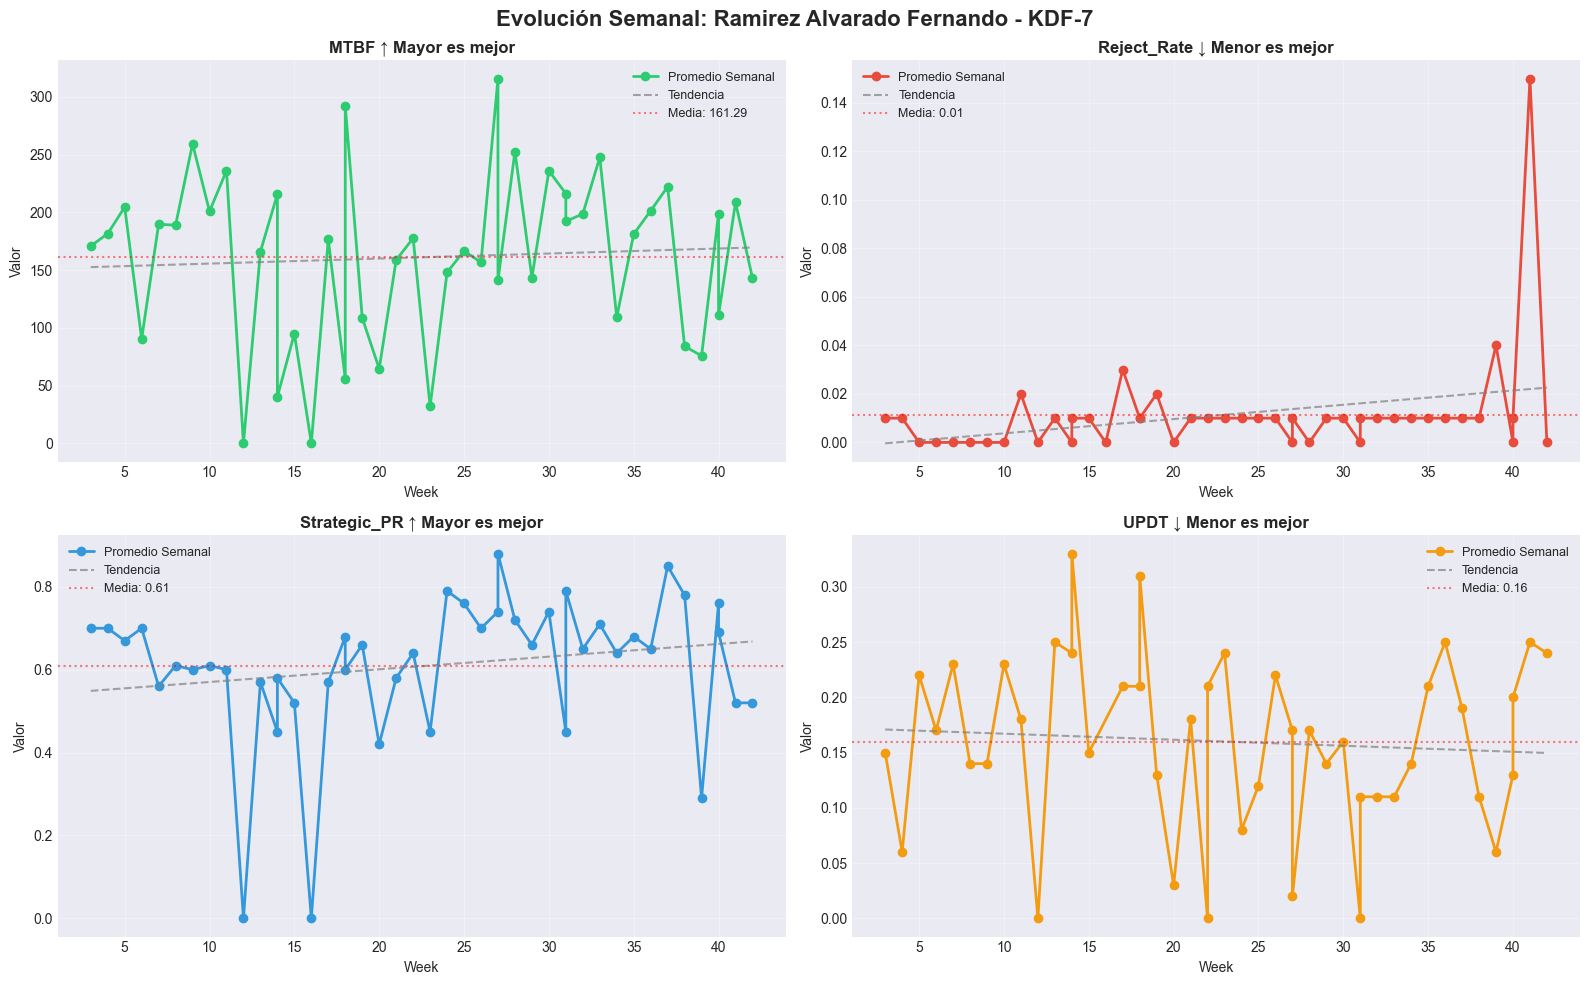


📊 Resumen de Ramirez Alvarado Fernando en KDF-7:

MTBF:
   Promedio general: 161.29
   Mejor valor: 315.82
   Peor valor: 0.00

Reject_Rate:
   Promedio general: 0.01
   Mejor valor: 0.00
   Peor valor: 0.15

Strategic_PR:
   Promedio general: 0.61
   Mejor valor: 0.88
   Peor valor: 0.00

UPDT:
   Promedio general: 0.16
   Mejor valor: 0.00
   Peor valor: 0.33


In [46]:
# Seleccionar un operador y una máquina de ejemplo
operador_ejemplo = 'Ramirez Alvarado Fernando'
maquina_ejemplo = 'KDF-7'

# Filtrar datos
df_ejemplo = df_weekly[
    (df_weekly['Operador'] == operador_ejemplo) & 
    (df_weekly['Maquina'] == maquina_ejemplo)
].copy()

# Crear figura con 4 subplots (uno por indicador)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Evolución Semanal: {operador_ejemplo} - {maquina_ejemplo}', 
             fontsize=16, fontweight='bold')

indicators = ['MTBF', 'Reject_Rate', 'Strategic_PR', 'UPDT']
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']
better_direction = ['↑ Mayor es mejor', '↓ Menor es mejor', '↑ Mayor es mejor', '↓ Menor es mejor']

for idx, (indicator, color, direction) in enumerate(zip(indicators, colors, better_direction)):
    ax = axes[idx // 2, idx % 2]
    
    df_ind = df_ejemplo[df_ejemplo['Indicador'] == indicator].sort_values('Week')
    
    if len(df_ind) > 0:
        # Línea principal
        ax.plot(df_ind['Week'], df_ind['Valor_Promedio'], 
                marker='o', linewidth=2, markersize=6, color=color, label='Promedio Semanal')
        
        # Línea de tendencia
        z = np.polyfit(df_ind['Week'], df_ind['Valor_Promedio'], 1)
        p = np.poly1d(z)
        ax.plot(df_ind['Week'], p(df_ind['Week']), 
                linestyle='--', linewidth=1.5, color='gray', alpha=0.7, label='Tendencia')
        
        # Media general
        mean_val = df_ind['Valor_Promedio'].mean()
        ax.axhline(y=mean_val, color='red', linestyle=':', linewidth=1.5, 
                   alpha=0.5, label=f'Media: {mean_val:.2f}')
        
        ax.set_title(f'{indicator} {direction}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Week', fontsize=10)
        ax.set_ylabel('Valor', fontsize=10)
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Sin datos', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen de {operador_ejemplo} en {maquina_ejemplo}:")
for indicator in indicators:
    df_ind = df_ejemplo[df_ejemplo['Indicador'] == indicator]
    if len(df_ind) > 0:
        promedio = df_ind['Valor_Promedio'].mean()
        mejor = df_ind['Valor_Promedio'].min() if indicator in ['Reject_Rate', 'UPDT'] else df_ind['Valor_Promedio'].max()
        peor = df_ind['Valor_Promedio'].max() if indicator in ['Reject_Rate', 'UPDT'] else df_ind['Valor_Promedio'].min()
        
        print(f"\n{indicator}:")
        print(f"   Promedio general: {promedio:.2f}")
        print(f"   Mejor valor: {mejor:.2f}")
        print(f"   Peor valor: {peor:.2f}")

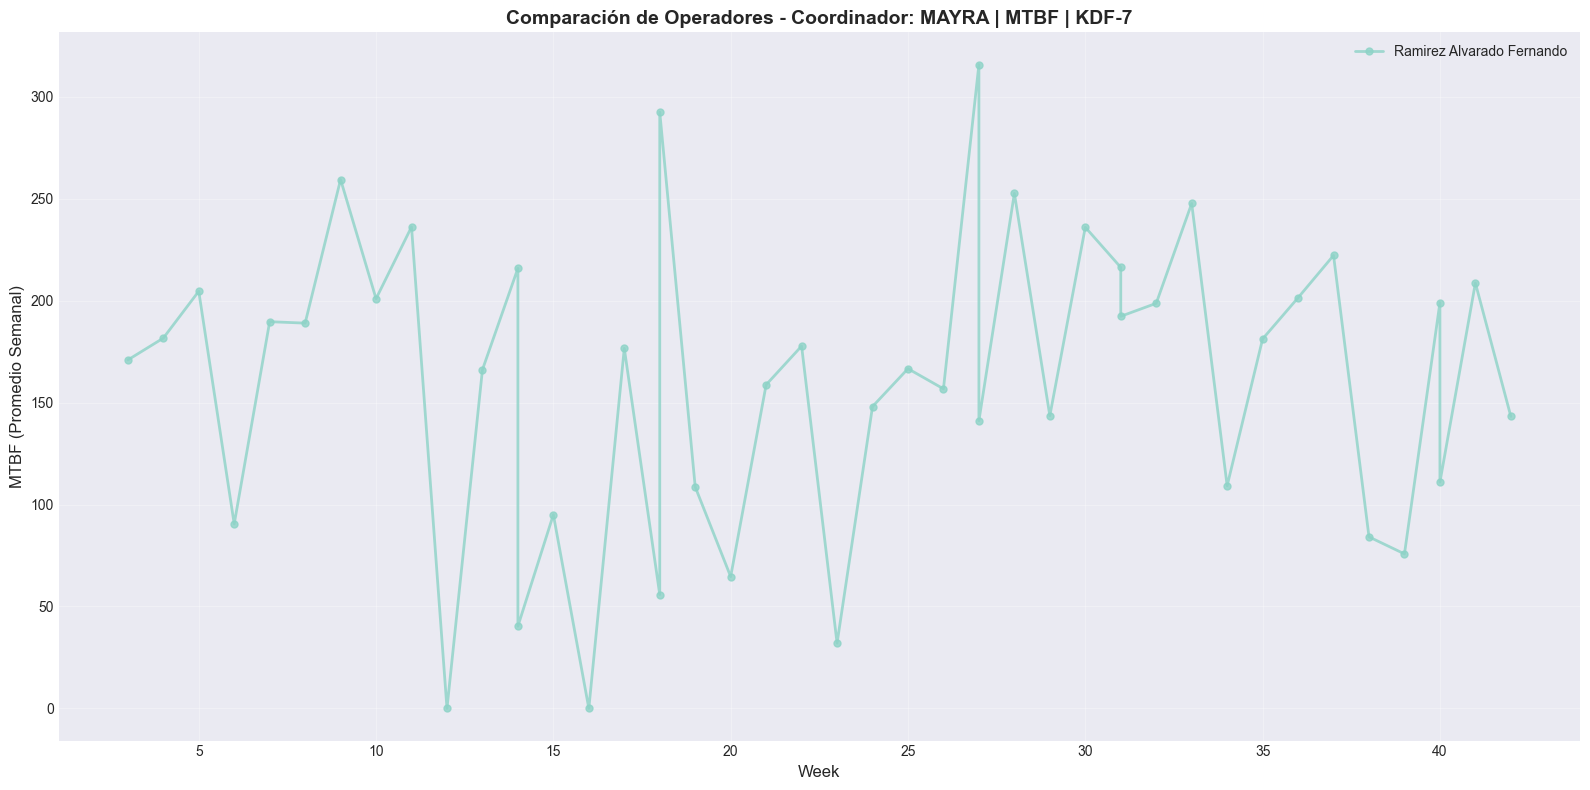


📊 Ranking de operadores del coordinador MAYRA en KDF-7 (MTBF):
   1. Ramirez Alvarado Fernando: 161.29


In [43]:
# Seleccionar un coordinador y un indicador
coordinador_ejemplo = 'MAYRA'
indicador_ejemplo = 'MTBF'
maquina_comp = 'KDF-7'

# Filtrar datos
df_comp = df_weekly[
    (df_weekly['Coordinador'] == coordinador_ejemplo) & 
    (df_weekly['Maquina'] == maquina_comp) &
    (df_weekly['Indicador'] == indicador_ejemplo)
].copy()

# Crear gráfica
plt.figure(figsize=(16, 8))

operadores_coord = df_comp['Operador'].unique()
colors_op = plt.cm.Set3(np.linspace(0, 1, len(operadores_coord)))

for idx, operador in enumerate(operadores_coord):
    df_op = df_comp[df_comp['Operador'] == operador].sort_values('Week')
    plt.plot(df_op['Week'], df_op['Valor_Promedio'], 
             marker='o', linewidth=2, markersize=5, 
             color=colors_op[idx], label=operador, alpha=0.8)

plt.title(f'Comparación de Operadores - Coordinador: {coordinador_ejemplo} | {indicador_ejemplo} | {maquina_comp}', 
          fontsize=14, fontweight='bold')
plt.xlabel('Week', fontsize=12)
plt.ylabel(f'{indicador_ejemplo} (Promedio Semanal)', fontsize=12)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Ranking de operadores del coordinador {coordinador_ejemplo} en {maquina_comp} ({indicador_ejemplo}):")
ranking = df_comp.groupby('Operador')['Valor_Promedio'].mean().sort_values(ascending=False)
for idx, (operador, promedio) in enumerate(ranking.items(), 1):
    print(f"   {idx}. {operador}: {promedio:.2f}")

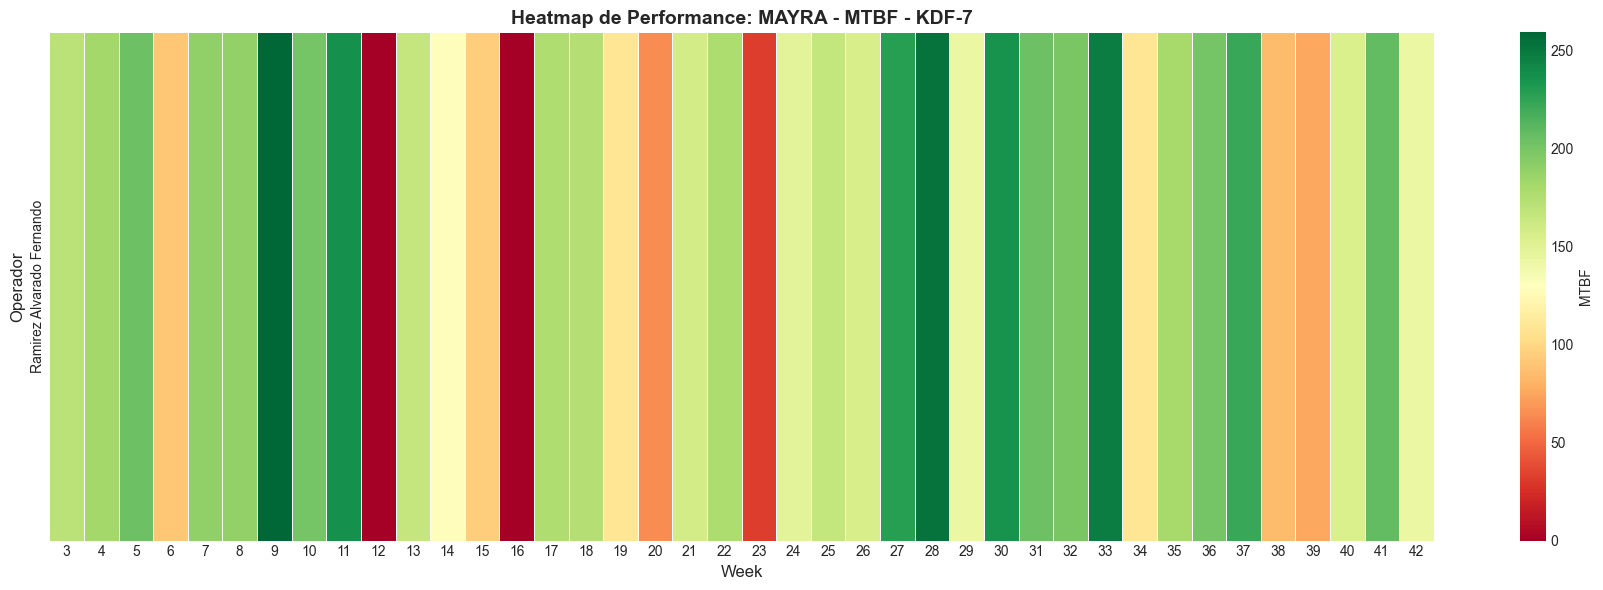


📊 Interpretación del Heatmap:
   🟢 Verde: Mejor performance
   🟡 Amarillo: Performance media
   🔴 Rojo: Menor performance


In [44]:
# Crear heatmap: Operadores vs Weeks para un indicador
coordinador_heat = 'MAYRA'
indicador_heat = 'MTBF'
maquina_heat = 'KDF-7'

# Filtrar datos
df_heat = df_weekly[
    (df_weekly['Coordinador'] == coordinador_heat) & 
    (df_weekly['Maquina'] == maquina_heat) &
    (df_weekly['Indicador'] == indicador_heat)
].copy()

# Crear pivot table
pivot_data = df_heat.pivot_table(
    values='Valor_Promedio',
    index='Operador',
    columns='Week',
    aggfunc='mean'
)

# Crear heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(pivot_data, annot=False, fmt='.1f', cmap='RdYlGn', 
            linewidths=0.5, cbar_kws={'label': indicador_heat})
plt.title(f'Heatmap de Performance: {coordinador_heat} - {indicador_heat} - {maquina_heat}', 
          fontsize=14, fontweight='bold')
plt.xlabel('Week', fontsize=12)
plt.ylabel('Operador', fontsize=12)
plt.tight_layout()
plt.show()

print("\n📊 Interpretación del Heatmap:")
print("   🟢 Verde: Mejor performance")
print("   🟡 Amarillo: Performance media")
print("   🔴 Rojo: Menor performance")

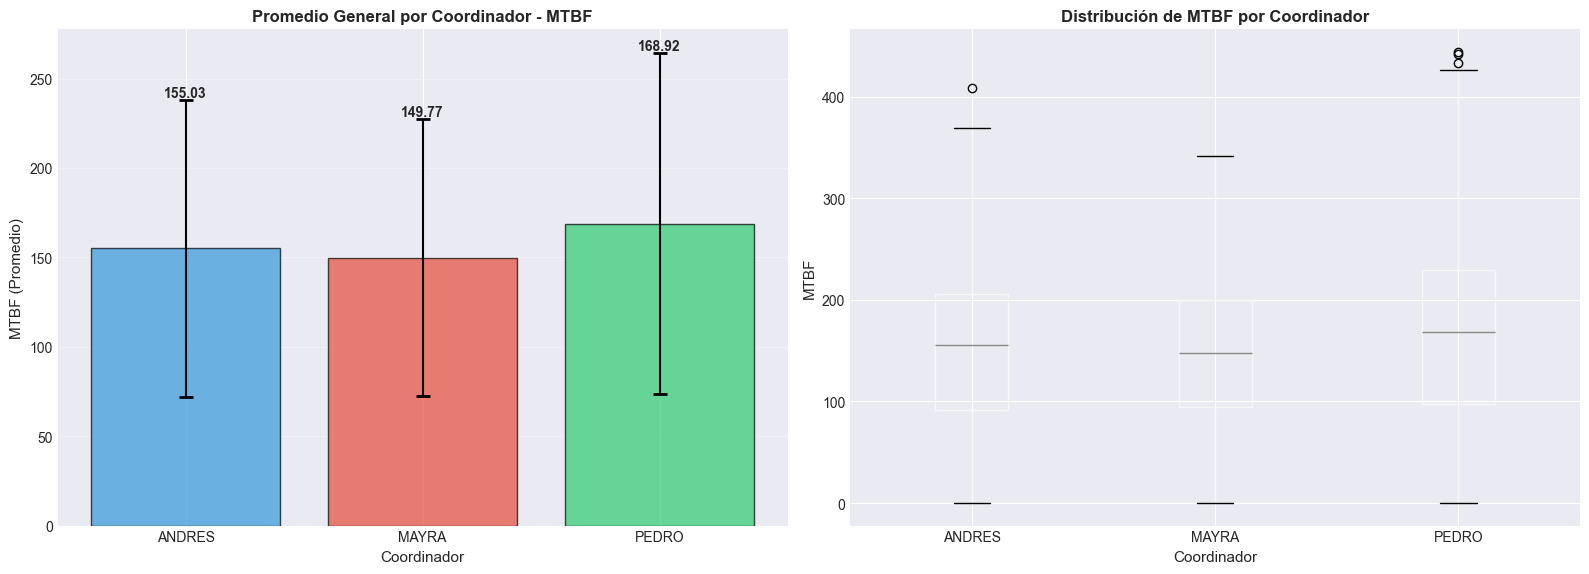


📊 Estadísticas por Coordinador (MTBF):
                   mean        std  count
Coordinador                              
ANDRES       155.031065  83.264599    263
MAYRA        149.772015  77.446340    263
PEDRO        168.917186  95.356523    263


In [45]:
# Comparar promedios generales por coordinador
indicador_coord = 'MTBF'

df_coord_comp = df_weekly[df_weekly['Indicador'] == indicador_coord].copy()

# Calcular promedio por coordinador
coord_stats = df_coord_comp.groupby('Coordinador')['Valor_Promedio'].agg(['mean', 'std', 'count'])

# Crear gráfica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica 1: Barras con promedio
ax1.bar(coord_stats.index, coord_stats['mean'], 
        color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
ax1.errorbar(coord_stats.index, coord_stats['mean'], yerr=coord_stats['std'], 
             fmt='none', color='black', capsize=5, capthick=2)
ax1.set_title(f'Promedio General por Coordinador - {indicador_coord}', 
              fontsize=12, fontweight='bold')
ax1.set_ylabel(f'{indicador_coord} (Promedio)', fontsize=11)
ax1.set_xlabel('Coordinador', fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Añadir valores sobre las barras
for idx, (coord, val) in enumerate(zip(coord_stats.index, coord_stats['mean'])):
    ax1.text(idx, val + coord_stats['std'].iloc[idx], f'{val:.2f}', 
             ha='center', va='bottom', fontweight='bold')

# Gráfica 2: Boxplot para ver distribución
df_coord_comp.boxplot(column='Valor_Promedio', by='Coordinador', ax=ax2)
ax2.set_title(f'Distribución de {indicador_coord} por Coordinador', fontsize=12, fontweight='bold')
ax2.set_xlabel('Coordinador', fontsize=11)
ax2.set_ylabel(f'{indicador_coord}', fontsize=11)
plt.suptitle('')  # Remover título automático del boxplot

plt.tight_layout()
plt.show()

print(f"\n📊 Estadísticas por Coordinador ({indicador_coord}):")
print(coord_stats)